# Déployez un modèle dans le cloud


# Sommaire :

**1. Préambule**<br />
&emsp;1.1 Problématique<br />
&emsp;1.2 Objectifs dans ce projet<br />
&emsp;1.3 Déroulement des étapes du projet<br />
**2. Choix techniques généraux retenus**<br />
&emsp;2.1 Calcul distribué<br />
&emsp;2.2 Transfert Learning<br />
**3. Déploiement de la solution sur le cloud**<br />
&emsp;3.1 Choix du prestataire cloud : AWS<br />
&emsp;3.2 Choix de la solution technique : EMR<br />
&emsp;3.3 Choix de la solution de stockage des données : Amazon S3<br />
&emsp;3.4 Configuration de l'environnement de travail<br />
&emsp;3.5 Upload de nos données sur S3<br />
&emsp;3.6 Configuration du serveur EMR<br />
&emsp;&emsp;3.6.1 Étape 1 : Logiciels et étapes<br />
&emsp;&emsp;&emsp;3.6.1.1 Configuration des logiciels<br />
&emsp;&emsp;&emsp;3.6.1.2 Modifier les paramètres du logiciel<br />
&emsp;&emsp;3.6.2 Étape 2 : Matériel<br />
&emsp;&emsp;3.6.3 Étape 3 : Paramètres de cluster généraux<br />
&emsp;&emsp;&emsp;3.6.3.1 Options générales<br />
&emsp;&emsp;&emsp;3.6.3.2 Actions d'amorçage<br />
&emsp;&emsp;3.6.4 Étape 4 : Sécurité<br />
&emsp;&emsp;&emsp;3.6.4.1 Options de sécurité<br />
&emsp;3.7 Instanciation du serveur<br />
&emsp;3.8 Création du tunnel SSH à l'instance EC2 (Maître)<br />
&emsp;&emsp;3.8.1 Création des autorisations sur les connexions entrantes<br />
&emsp;&emsp;3.8.2 Création du tunnel ssh vers le Driver<br />
&emsp;&emsp;3.8.3 Configuration de FoxyProxy<br />
&emsp;&emsp;3.8.4 Accès aux applications du serveur EMR via le tunnel ssh<br />
&emsp;3.9 Connexion au notebook JupyterHub<br />
&emsp;3.10 Exécution du code<br />
&emsp;&emsp;3.10.1 Installation des packages<br />
&emsp;&emsp;3.10.2 Import des librairies<br />
&emsp;&emsp;3.10.3 Définition des PATH pour charger les images et enregistrer les résultats<br />
&emsp;&emsp;3.10.4 Création de la SparkSession<br />
&emsp;&emsp;3.10.5 Traitement des données<br />
&emsp;&emsp;&emsp;3.10.5.1 Chargement des données<br />
&emsp;&emsp;&emsp;3.10.5.2 Préparation du modèle<br />
&emsp;&emsp;&emsp;3.10.5.3 Définition du processus de chargement des images<br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;et application de leur featurisation à travers l'utilisation de pandas UDF<br />
&emsp;&emsp;&emsp;3.10.5.4 Exécutions des actions d'extractions de features<br />
&emsp;&emsp;3.10.6 Application d'une PCA<br />
&emsp;&emsp;3.10.7 Chargement des données enregistrées et validation du résultat<br />
&emsp;3.11 Suivi de l'avancement des tâches avec le Serveur d'Historique Spark<br />
&emsp;3.12 Résiliation de l'instance EMR<br />
&emsp;3.13 Cloner le serveur EMR (si besoin)<br />
&emsp;3.14 Arborescence du serveur S3 à la fin du projet<br />

**4. Conclusion**<br />

# 1. Préambule

## 1.1 Problématique

La très jeune start-up de l'AgriTech, nommée "**Fruits**!", <br />
cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits <br />
en permettant des traitements spécifiques pour chaque espèce de fruits <br />
en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant <br />
à disposition du grand public une application mobile qui permettrait aux <br />
utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public <br /> 
à la biodiversité des fruits et de mettre en place une première version du moteur <br />
de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire <br />
une première version de l'architecture **Big Data** nécessaire.

## 1.2 Objectifs dans ce projet

1. Développer une première chaîne de traitement des données qui <br />
   comprendra le **preprocessing** et une étape de **réduction de dimension**.
2. Tenir compte du fait que <u>le volume de données va augmenter <br />
   très rapidement</u> après la livraison de ce projet, ce qui implique de:
 - Déployer le traitement des données dans un environnement **Big Data**
 - Développer les scripts en **pyspark** pour effectuer du **calcul distribué**

## 1.3 Déroulement des étapes du projet

Le projet va être réalisé en 2 temps, dans deux environnements différents. <br />
Nous allons dans un premier temps développer et exécuter notre code en local, <br />
en travaillant sur un nombre limité d'images à traiter.

Une fois les choix techniques validés, nous déploierons notre solution <br />
dans un environnement Big Data en mode distribué.

<u>Pour cette raison, ce projet sera divisé en 3 parties</u>:
1. Liste des choix techniques généraux retenus
2. Déploiement de la solution en local
3. Déploiement de la solution dans le cloud

# 2. Choix techniques généraux retenus

## 2.1 Calcul distribué

L’énoncé du projet nous impose de développer des scripts en **pyspark** <br />
afin de <u>prendre en compte l’augmentation très rapide du volume <br />
de donné après la livraison du projet</u>.

Pour comprendre rapidement et simplement ce qu’est **pyspark** <br />
et son principe de fonctionnement, nous vous conseillons de lire <br />
cet article : [PySpark : Tout savoir sur la librairie Python](https://datascientest.com/pyspark)

<u>Le début de l’article nous dit ceci </u>:<br />
« *Lorsque l’on parle de traitement de bases de données sur python, <br />
on pense immédiatement à la librairie pandas. Cependant, lorsqu’on a <br />
affaire à des bases de données trop massives, les calculs deviennent trop lents.<br />
Heureusement, il existe une autre librairie python, assez proche <br />
de pandas, qui permet de traiter des très grandes quantités de données : PySpark.<br />
Apache Spark est un framework open-source développé par l’AMPLab <br />
de UC Berkeley permettant de traiter des bases de données massives <br />
en utilisant le calcul distribué, technique qui consiste à exploiter <br />
plusieurs unités de calcul réparties en clusters au profit d’un seul <br />
projet afin de diviser le temps d’exécution d’une requête.<br />
Spark a été développé en Scala et est au meilleur de ses capacités <br />
dans son langage natif. Cependant, la librairie PySpark propose de <br />
l’utiliser avec le langage Python, en gardant des performances <br />
similaires à des implémentations en Scala.<br />
Pyspark est donc une bonne alternative à la librairie pandas lorsqu’on <br />
cherche à traiter des jeux de données trop volumineux qui entraînent <br />
des calculs trop chronophages.* »

Comme nous le constatons, **pySpark** est un moyen de communiquer <br />
avec **Spark** via le langage **Python**.<br />
**Spark**, quant à lui, est un outil qui permet de gérer et de coordonner <br />
l'exécution de tâches sur des données à travers un groupe d'ordinateurs. <br />
<u>Spark (ou Apache Spark) est un framework open source de calcul distribué <br />
in-memory pour le traitement et l'analyse de données massives</u>.

Un autre [article très intéressant et beaucoup plus complet pour <br />
comprendre le **fonctionnement de Spark**](https://www.veonum.com/apache-spark-pour-les-nuls/), ainsi que le rôle <br />
des **Spark Session** que nous utiliserons dans ce projet.

<u>Voici également un extrait</u>:

*Les applications Spark se composent d’un pilote (« driver process ») <br />
et de plusieurs exécuteurs (« executor processes »). Il peut être configuré <br />
pour être lui-même l’exécuteur (local mode) ou en utiliser autant que <br />
nécessaire pour traiter l’application, Spark prenant en charge la mise <br />
à l’échelle automatique par une configuration d’un nombre minimum <br />
et maximum d’exécuteurs.*

![Schéma de Spark](img/spark-schema.png)

*Le driver (parfois appelé « Spark Session ») distribue et planifie <br />
les tâches entre les différents exécuteurs qui les exécutent et permettent <br />
un traitement réparti. Il est le responsable de l’exécution du code <br />
sur les différentes machines.

Chaque exécuteur est un processus Java Virtual Machine (JVM) distinct <br />
dont il est possible de configurer le nombre de CPU et la quantité de <br />
mémoire qui lui est alloué. <br />
Une seule tâche peut traiter un fractionnement de données à la fois.*

Dans les deux environnements (Local et Cloud) nous utiliserons donc **Spark** <br />
et nous l’exploiterons à travers des scripts python grâce à **PySpark**.

Dans la <u>version locale</u> de notre script nous **simulerons <br />
le calcul distribué** afin de valider que notre solution fonctionne.<br />
Dans la <u>version cloud</u> nous **réaliserons les opérations sur un cluster de machine**.

## 2.2 Transfert Learning

L'énoncé du projet nous demande également de <br />
réaliser une première chaîne de traitement <br />
des données qui comprendra le preprocessing et <br />
une étape de réduction de dimension.

Il est également précisé qu'il n'est pas nécessaire <br />
d'entraîner un modèle pour le moment.

Nous décidons de partir sur une solution de **transfert learning**.

Simplement, le **transfert learning** consiste <br />
à utiliser la connaissance déjà acquise <br />
par un modèle entraîné (ici **MobileNetV2**) pour <br />
l'adapter à notre problématique.

Nous allons fournir au modèle nos images, et nous allons <br />
<u>récupérer l'avant dernière couche</u> du modèle.<br />
En effet la dernière couche de modèle est une couche softmax <br />
qui permet la classification des images ce que nous ne <br />
souhaitons pas dans ce projet.

L'avant dernière couche correspond à un **vecteur <br />
réduit** de dimension (1,1,1280).

Cela permettra de réaliser une première version du moteur <br />
pour la classification des images des fruits.

**MobileNetV2** a été retenu pour sa <u>rapidité d'exécution</u>, <br />
particulièrement adaptée pour le traitement d'un gros volume <br />
de données ainsi que la <u>faible dimensionnalité du vecteur <br />
de caractéristique en sortie</u> (1,1,1280)

# 3. Déploiement de la solution sur le cloud

Maintenant que nous avons vérifié que notre solution fonctionne, <br />
il est temps de la <u>déployer à plus grande échelle sur un vrai cluster de machines</u>.

**Attention**, *je travaille sous Linux avec une version Ubuntu, <br />
les commandes décrites ci-dessous sont donc réalisées <br />
exclusivement dans cet environnement.*

<u>Plusieurs contraintes se posent</u> :
 1. Quel prestataire de Cloud choisir ?
 2. Quelles solutions de ce prestataire adopter ?
 3. Où stocker nos données ?
 4. Comment configurer nos outils dans ce nouvel environnement ?
 
## 3.1 Choix du prestataire cloud : AWS

Le prestataire le plus connu et qui offre à ce jour l'offre <br />
la plus large dans le cloud computing est **Amazon Web Services** (AWS).<br />
Certaines de leurs offres sont parfaitement adaptées à notre problématique <br />
et c'est la raison pour laquelle j'utiliserai leurs services.

L'objectif premier est de pouvoir, grâce à AWS, <u>louer de la puissance de calcul à la demande</u>. <br />
L'idée étant de pouvoir, quel que soit la charge de travail, <br />
obtenir suffisamment de puissance de calcul pour pouvoir traiter nos images, <br />
même si le volume de données venait à fortement augmenter.

De plus, la capacité d'utiliser cette puissance de calcul à la demande <br />
permet de diminuer drastiquement les coûts si l'on compare les coûts d'une location <br />
de serveur complet sur une durée fixe (1 mois, 1 année par exemple).

## 3.2 Choix de la solution technique : EMR

<u>Plusieurs solutions s'offre à nous</u> :
1. Solution **IAAS** (Infrastructure AS A Service)
 - Dans cette configuration **AWS** met à notre disposition des serveurs vierges <br />
   sur lequel nous avons un accès en administrateur, ils sont nommés **instance EC2**.<br />
   Pour faire simple, nous pouvons avec cette solution reproduire pratiquement <br />
   à l'identique la solution mis en œuvre en local sur notre machine.<br />
   <u>On installe nous-même l'intégralité des outils puis on exécute notre script</u> :
  - Installation de **Spark**, **Java** etc.
  - Installation de **Python** (via Anaconda par exemple)
  - Installation de **Jupyter Notebook**
  - Installation des **librairies complémentaires**
  - Il faudra bien évidement veiller à **implémenter les librairies 
    nécessaires à toutes les machines (workers) du cluster**
  - <u>Avantages</u> :
      - Liberté totale de mise en œuvre de la solution
      - Facilité de mise en œuvre à partir d'un modèle qui s'exécute en local sur une machine Linux
  - <u>Inconvénients</u> :
      - Cronophage
          - Nécessité d'installer et de configurer toute la solution
      - Possible problèmes techniques à l'installation des outils (des problématiques qui <br />
        n'existaient pas en local sur notre machine peuvent apparaitre sur le serveur EC2)
      - Solution non pérenne dans le temps, il faudra veiller à la mise à jour des outils <br />
        et éventuellement devoir réinstaller Spark, Java etc. 
2. Solution **PAAS** (Plateforme As A Service)
 - **AWS** fournit énormément de services différents, dans l'un de ceux-là <br />
   il existe une offre qui permet de louer des **instances EC2** <br />
   avec des applications préinstallées et configurées : il s'agit du **service EMR**.
 - **Spark** y sera déjà installé
 - Possibilité de demander l'installation de **Tensorflow** ainsi que **JupyterHub**
 - Possibilité d'indiquer des **packages complémentaires** à installer <br />
   à l'initialisation du serveur **sur l'ensemble des machines du cluster**.
 - <u>Avantages</u> :
     - Facilité de mise en œuvre
         - Il suffit de très peu de configuration pour obtenir <br />
           un environnement parfaitement fonctionnel
     - Rapidité de mise en œuvre
         - Une fois la première configuration réalisée, il est très facile <br />
           et très rapide de recréer des clusters à l'identique qui seront <br />
           disponibles presque instantanément (le temps d'instancier les <br />
           serveurs soit environ 15/20 minutes)
     - Solutions matérielless et logicielles optimisées par les ingénieurs d'AWS
         - On sait que les versions installées vont fonctionner <br />
           et que l'architecture proposée est optimisée
     - Stabilité de la solution
    - Solution évolutive
        Il est facile d’obtenir à chaque nouvelle instanciation une version à jour <br />
        de chaque package, en étant garanti de leur compatibilité avec le reste de l’environnement.
  - Plus sécurisé
	- Les éventuels patchs de sécurité seront automatiquement mis à jour <br />
      à chaque nouvelle instanciation du cluster EMR.
 - <u>Inconvénients</u> :
     - Peut-être un certain manque de liberté sur la version des packages disponibles ? <br />
       Même si je n'ai pas constaté ce problème.
   

Je retiens la solution **PAAS** en choisissant d'utiliser <br />
le service **EMR** d'Amazon Web Services.<br />
Je la trouve plus adaptée à notre problématique et permet <br />
une mise en œuvre qui soit à la fois plus rapide et <br />
plus efficace que la solution IAAS.

## 3.3 Choix de la solution de stockage des données : Amazon S3

<u>Amazon propose une solution très efficace pour la gestion du stockage des données</u> : **Amazon S3**. <br />
S3 pour Amazon Simple Storage Service.

Il pourrait être tentant de stocker nos données sur l'espace alloué par le serveur **EC2**, <br />
mais si nous ne prenons aucune mesure pour les sauvegarder ensuite sur un autre support, <br />
<u>les données seront perdues</u> lorsque le serveur sera résilié (on résilie le serveur lorsqu'on <br />
ne s'en sert pas pour des raisons de coût).<br />
De fait, si l'on décide d'utiliser l'espace disque du serveur EC2 il faudra imaginer <br />
une solution pour sauvegarder les données avant la résiliation du serveur.
De plus, nous serions exposés à certaines problématiques si nos données venaient à <br />
**saturer** l'espace disponible de nos serveurs (ralentissements, disfonctionnements).

<u>Utiliser **Amazon S3** permet de s'affranchir de toutes ces problématiques</u>. <br />
L'espace disque disponible est **illimité**, et il est **indépendant de nos serveurs EC2**. <br />
L'accès aux données est **très rapide** car nous restons dans l'environnement d'AWS <br />
et nous prenons soin de <u>choisir la même région pour nos serveurs **EC2** et **S3**</u>.

De plus, comme nous le verrons <u>il est possible d'accéder aux données sur **S3** <br />
    de la même manière que l'on **accède aux données sur un disque local**</u>.<br />
Nous utiliserons simplement un **PATH au format s3://...** .

## 3.4 Configuration de l'environnement de travail

La première étape est d'installer et de configurer [**AWS Cli**](https://aws.amazon.com/fr/cli/),<br />
il s'agit de l'**interface en ligne de commande d'AWS**.<br />
Elle nous permet d'**interagir avec les différents services d'AWS**, comme **S3** par exemple.

Pour pouvoir utiliser **AWS Cli**, il faut le configurer en créant préalablement <br />
un utilisateur à qui on donnera les autorisations dont nous aurons besoin.<br />
Dans ce projet il faut que l'utilisateur ait à minima un contrôle total sur le service S3.

<u>La gestion des utilisateurs et de leurs droits s'effectue via le service **AMI**</u> d'AWS.

Une fois l'utilisateur créé et ses autorisations configurées nous créons une **paire de clés** <br />
qui nous permettra de nous **connecter sans à avoir à devoir saisir systématiquement notre login/mot de passe**.<br />

Il faut également configurer l'**accès SSH** à nos futurs serveurs EC2. <br />
Ici aussi, via un système de clés qui nous dispense de devoir nous authentifier "à la main" à chaque connexion.

Toutes ses étapes de configuration sont parfaitement décrites <br />
dans le cours du projet: [Réalisez des calculs distribués sur des données massives / Découvrez Amazon Web Services](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308686-decouvrez-amazon-web-services#/id/r-4355822)

## 3.5 Upload de nos données sur S3

Nos outils sont configurés. <br />
Il faut maintenant uploader nos données de travail sur Amazon S3.

Ici aussi les étapes sont décrites avec précision <br />
dans le cours [Réalisez des calculs distribués sur des données massives / Stockez des données sur S3](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308691-stockez-des-donnees-sur-s3)

Je décide de n'uploader que les données contenues dans le dossier **Test** du [jeu de données du projet](https://www.kaggle.com/moltean/fruits/download)


La première étape consiste à **créer un bucket sur S3** <br />
dans lequel nous uploaderons les données du projet:
- **aws s3 mb s3://p8-data**

On vérifie que le bucket à bien été créé
- **aws s3 ls**
 - Si le nom du bucket s'affiche alors c'est qu'il a été correctement créé.

On copie ensuite le contenu du dossier "**Test**" <br />
dans un répertoire "**Test**" sur notre bucket "**p8-data**":
1. On se place à l'intérieur du répertoire **Test**
2. **aws sync . s3://p8-data/Test**

La commande **sync** est utile pour synchroniser deux répertoires.

<u>Nos données du projet sont maintenant disponibles sur Amazon S3</u>.

## 3.6 Configuration du serveur EMR

Une fois encore, le cours [Réalisez des calculs distribués sur des données massives / Déployez un cluster de calculs distribués](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308696-deployez-un-cluster-de-calculs-distribues) <br /> détaille l'essentiel des étapes pour lancer un cluster avec **EMR**.

<u>Je détaillerai ici les étapes particulières qui nous permettent <br />
de configurer le serveur selon nos besoins</u> :

1. Cliquez sur Créer un cluster
![Créer un cluster](img/EMR_creer.png)
2. Cliquez sur Accéder aux options avancées
![Créer un cluster](img/EMR_options_avancees.png)

### 3.6.1 Étape 1 : Logiciels et étapes

#### 3.6.1.1 Configuration des logiciels

<u>Sélectionnez les packages dont nous aurons besoin comme dans la capture d'écran</u> :
1. Nous sélectionnons la dernière version d'**EMR**, soit la version **6.3.0** au moment où je rédige ce document
2. Nous cochons bien évidement **Hadoop** et **Spark** qui seront préinstallés dans leur version la plus récente
3. Nous aurons également besoin de **TensorFlow** pour importer notre modèle et réaliser le **transfert learning**
4. Nous travaillerons enfin avec un **notebook Jupyter** via l'application **JupyterHub**<br />
 - Comme nous le verrons dans un instant nous allons <u>paramétrer l'application afin que les notebooks</u>, <br />
   comme le reste de nos données de travail, <u>soient enregistrés directement sur S3</u>.
![Créer un cluster](img/EMR_configuration_logiciels.png)

#### 3.6.1.2 Modifier les paramètres du logiciel

<u>Paramétrez la persistance des notebooks créés et ouvert via JupyterHub</u> :
- On peut à cette étape effectuer des demandes de paramétrage particulières sur nos applications. <br />
  L'objectif est, comme pour le reste de nos données de travail, <br />
  d'éviter toutes les problématiques évoquées précédemment. <br />
  C'est l'objectif à cette étape, <u>nous allons enregistrer <br />
  et ouvrir les notebooks</u> non pas sur l'espace disque de  l'instance EC2 (comme <br />
  ce serait le cas dans la configuration par défaut de JupyterHub) mais <br />
  <u>directement sur **Amazon S3**</u>.
- <u>deux solutions sont possibles pour réaliser cela</u> :
 1. Créer un **fichier de configuration JSON** que l'on **upload sur S3** et on indique ensuite le chemin d’accès au fichier JSON
 2. Rentrez directement la configuration au format JSON
 
J'ai personnellement créé un fichier JSON lors de la création de ma première instance EMR, <br />
puis lorsqu'on décide de cloner notre serveur pour en recréer un facilement à l'identique, <br />
la configuration du fichier JSON se retrouve directement copié comme dans la capture ci-dessous.

<u>Voici le contenu de mon fichier JSON</u> :  [{"classification":"jupyter-s3-conf","properties":{"s3.persistence.bucket":"p8-data","s3.persistence.enabled":"true"}}]
 Appuyez ensuite sur "**Suivant**"
![Modifier les paramètres du logiciel](img/EMR_parametres_logiciel.png)

### 3.6.2 Étape 2 : Matériel

A cette étape, laissez les choix par défaut. <br />
<u>L'important ici est la sélection de nos instances</u> :

1. je choisi les instances de type **M5** qui sont des **instances de type équilibrés**
2. je choisi le type **xlarge** qui est l'instance la **moins onéreuse disponible**
 [Plus d'informations sur les instances M5 Amazon EC2](https://aws.amazon.com/fr/ec2/instance-types/m5/)
3. Je sélectionne **1 instance Maître** (le driver) et **2 instances Principales** (les workeurs) <br />
   soit **un total de 3 instance EC2**.
![Choix du materiel](img/EMR_materiel.png)

### 3.6.3 Étape 3 : Paramètres de cluster généraux

#### 3.6.3.1 Options générales
<u>La première chose à faire est de donner un nom au cluster</u> :<br />
*J'ai également décoché "Protection de la résiliation" pour des raisons pratiques.*
    
![Nom du Cluster](img/EMR_nom_cluster.png)

#### 3.6.3.2 Actions d'amorçage

Nous allons à cette étape **choisir les packages manquants à installer** et qui <br />
nous serons utiles dans l'exécution de notre notebook.<br />
<u>L'avantage de réaliser cette étape maintenant est que les packages <br />
installés le seront sur l'ensemble des machines du cluster</u>.

La procédure pour créer le fichier **bootstrap** qui contient <br />
l'ensemble des instructions permettant d'installer tous <br />
les packages dont nous aurons besoin est expliqué dans <br />
le cours [Réalisez des calculs distribués sur des données massives / Bootstrapping](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308696-deployez-un-cluster-de-calculs-distribues#/id/r-4356490)

Nous créons donc un fichier nommé "**bootstrap-emr.sh**" que nous <u>uploadons <br />
sur S3</u>(je l’installe à la racine de mon **bucket "p8-data"**) et nous l'ajoutons <br />
comme indiqué dans la capture d'écran ci-dessous:
![Actions d'amorcage](img/EMR_amorcage.png)

Voici le contenu du fichier **bootstrap-emr.sh**<br />
Comme on peut le constater il s'agit simplement de commande "**pip install**" <br />
pour **installer les bibliothèques manquantes** comme réalisé en local.<br />
Une fois encore, <u>il est nécessaire de réaliser ces actions à cette étape</u> <br />
pour que <u>les packages soient installés sur l'ensemble des machines du cluster</u> <br />
et non pas uniquement sur le driver, comme cela serait le cas si nous exécutions <br />
ces commandes directement dans le notebook JupyterHub ou dans la console EMR (connecté au driver).
![Contenu du fichier bootstrap](img/EMR_bootstrap.png)

**setuptools** et **pip** sont mis à jour pour éviter une problématique <br />
avec l'installation du package **pyarrow**.<br />
**Pandas** a eu droit à une mise à jour majeur (1.3.0) il y a moins d'une semaine <br />
au moment de la rédaction de ce notebook, et la nouvelle version de **Pandas** <br />
nécessite une version plus récente de **Numpy** que la version installée par <br />
défaut (1.16.5) à l'initialisation des instances **EC2**. <u>Il ne semble pas <br />
possible d'imposer une autre version de Numpy que celle installé par <br />
défaut</u> même si on force l'installation d'une version récente de **Numpy** <br />
(en tout cas, ni simplement ni intuitivement).<br />
La mise à jour étant très récente <u>la version de **Numpy** n'est pas encore <br />
mise à jour sur **EC2**</u> mais on peut imaginer que ce sera le cas très rapidement <br />
et il ne sera plus nécessaire d'imposer une version spécifique de **Pandas**.<br />
En attendant, je demande <u>l'installation de l'avant dernière version de **Pandas (1.2.5)**</u>

On clique ensuite sur ***Suivant***

### 3.6.4 Étape 4 : Sécurité

#### 3.6.4.1 Options de sécurité

A cette étape nous sélectionnons la **paire de clés EC2** créé précédemment. <br />
Elle nous permettra de se connecter en **ssh** à nos **instances EC2** <br />
sans avoir à entrer nos login/mot de passe.<br />
On laisse les autres paramètres par défaut. <br />
Et enfin, on clique sur "***Créer un cluster***"
 
![EMR Sécurité](img/EMR_securite.png)

## 3.7 Instanciation du serveur

Il ne nous reste plus qu'à attendre que le serveur soit prêt. <br />
Cette étape peut prendre entre **15 et 20 minutes**.

<u>Plusieurs étapes s'enchaîne, on peut suivre l'avancé du statut du **cluster EMR**</u> :

![Instanciation étape 1](img/EMR_instanciation_01.png)
![Instanciation étape 2](img/EMR_instanciation_02.png)
![Instanciation étape 3](img/EMR_instanciation_03.png)

<u>Lorsque le statut affiche en vert: "**En attente**" cela signifie que l'instanciation <br />
s'est bien déroulée et que notre serveur est prêt à être utilisé</u>. 

## 3.8 Création du tunnel SSH à l'instance EC2 (Maître)

### 3.8.1 Création des autorisations sur les connexions entrantes

<u>Nous souhaitons maintenant pouvoir accéder à nos applications</u> :
 - **JupyterHub** pour l'exécution de notre notebook
 - **Serveur d'historique Spark** pour le suivi de l'exécution <br />
   des tâches de notre script lorsqu'il sera lancé
 
Cependant, <u>ces applications ne sont accessibles que depuis le réseau local du driver</u>, <br />
et pour y accéder nous devons **créer un tunnel SSH vers le driver**.

Par défaut, ce driver se situe derrière un firewall qui bloque l'accès en SSH. <br />
<u>Pour ouvrir le port 22 qui correspond au port sur lequel écoute le serveur SSH, <br />
il faut modifier le **groupe de sécurité EC2 du driver**</u>.

Cette étape est décrite dans le cours [Réalisez des calculs distribués sur des données massives / Lancement d'une application à partir du driver](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308696-deployez-un-cluster-de-calculs-distribues#/id/r-4356512): 

*Il faudra que l'on se connecte en SSH au driver de notre cluster. <br />
Par défaut, ce driver se situe derrière un firewall qui bloque l'accès en SSH. <br />
Pour ouvrir le port 22 qui correspond au port sur lequel écoute le serveur SSH, <br />
il faut modifier le groupe de sécurité EC2 du driver. Sur la page de la console <br />
consacrée à EC2, dans l'onglet "Réseau et sécurité", cliquez sur "Groupes de sécurité". <br />
Vous allez devoir modifier le groupe de sécurité d’ElasticMapReduce-Master. <br />
Dans l'onglet "Entrant", ajoutez une règle SSH dont la source est "N'importe où" <br />
(ou "Mon IP" si vous disposez d'une adresse IP fixe).*

![Configuration autorisation ports entrants pour ssh](img/EMR_config_ssh_01.png)

<u>Une fois cette étape réalisée vous devriez avoir une configuration semblable à la mienne</u> :

![Configuration ssh terminée](img/EMR_config_ssh_02.png)

### 3.8.2 Création du tunnel ssh vers le Driver

On peut maintenant établir le **tunnel SSH** vers le **Driver**. <br />
Pour cela on récupère les informations de connexion fournis par Amazon <br />
depuis la page du service EMR / Cluster / onglet Récapitulatif en <br />
cliquant sur "**Activer la connexion Web**"

![Activer la connexion Web](img/EMR_tunnel_ssh_01.png)

<u>On récupère ensuite la commande fournis par Amazon pour **établir le tunnel SSH**</u> :

![Récupérer la commande pour établir le tunnel ssh](img/EMR_tunnel_ssh_02.png)

<u>Dans mon cas, la commande ne fonctionne pas tel</u> quel et j'ai du **l'adapter à ma configuration**. <br />
La **clé ssh** se situe dans un dossier "**.ssh**" elle-même située dans <br />
mon **répertoire personnel** dont le symbole est, sous Linux, identifié par un tilde "**~**".

Ayant suivi le cours [Réalisez des calculs distribués sur des données massives / Lancement d'une application à partir du driver](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives) <br />
j'ai choisi d'utiliser le port **5555** au lieu du **8157**, même si le choix n'est pas très important.<br />
    j'ai également rencontré un <u>problème de compatibilité</u> avec <br />
l'argument "**-N**" (liste des arguments et leur significations <br />
disponibles [ici](https://explainshell.com/explain?cmd=ssh+-L+-N+-f+-l+-D)) j'ai décidé de simplement le supprimer.

<u>Finalement, j'utilise la commande suivante dans un terminal pour établir <br />
    mon tunnel ssh (seul l'URL change d'une instance à une autre)</u> : <br />
"**ssh -i ~/.ssh/p8-ec2.pem -D 5555 hadoop@ec2-35-180-91-39.eu-west-3.compute.amazonaws.com**"

<u>On inscrit "**yes**" pour valider la connexion et si <br />
    la connexion est établit on obtient le résultat suivant</u> :

![Création du tunnel SSH](img/EMR_connexion_ssh_01.png)

Nous avons **correctement établi le tunnel ssh avec le driver** sur le port "5555".

### 3.8.3 Configuration de FoxyProxy

Une dernière étape est nécessaire pour accéder à nos applications, <br />
en demandant à notre navigateur d'emprunter le tunnel ssh.<br />
J'utilise pour cela **FoxyProxy**.
[Une fois encore, vous pouvez utiliser le cours pour le configurer](https://openclassrooms.com/fr/courses/4297166-realisez-des-calculs-distribues-sur-des-donnees-massives/4308701-realisez-la-maintenance-dun-cluster#/id/r-4356554).

Sinon, ouvrez la configuration de **FoxyProxy** et <u>cliquez sur **Ajouter**</u> en haut à gauche <br />
puis renseigner les éléments comme dans la capture ci-dessous :

![Configuration FoxyProxy Etape 1](img/EMR_foxyproxy_config_01.png)

<u>On obtient le résultat ci-dessous</u> :

![Configuration FoxyProxy Etape 2](img/EMR_foxyproxy_config_02.png)


### 3.8.4 Accès aux applications du serveur EMR via le tunnel ssh


<u>Avant d'établir notre **tunnel ssh** nous avions ça</u> :

![avant tunnel ssh](img/EMR_tunnel_ssh_avant.png)

<u>On active le **tunnel ssh** comme vu précédemment puis on demande <br />
à notre navigateur de l'utiliser avec **FoxyProxy**</u> :

![FoxyProxy activation](img/EMR_foxyproxy_activation.png)

<u>On peut maintenant s'apercevoir que plusieurs applications nous sont accessibles</u> :

![avant tunnel ssh](img/EMR_tunnel_ssh_apres.png)

## 3.9 Connexion au notebook JupyterHub

Pour se connecter à **JupyterHub** en vue d'exécuter notre **notebook**, <br />
il faut commencer par <u>cliquer sur l'application **JupyterHub**</u> apparu <br />
depuis que nous avons configuré le **tunnel ssh** et **foxyproxy** sur <br />
notre navigateur (actualisez la page si ce n’est pas le cas).

![Démarrage de JupyterHub](img/EMR_jupyterhub_connexion_01.png)

On passe les éventuels avertissements de sécurité puis <br />
nous arrivons sur une page de connexion.
    
<u>On se connecte avec les informations par défaut</u> :
 - <u>login</u>: **jovyan**
 - <u>password</u>: **jupyter**
 
![Connexion à JupyterHub](img/EMR_jupyterhub_connexion_02.png)

Nous arrivons ensuite dans un dossier vierge de notebook.<br />
Il suffit d'en créer un en cliquant sur "**New**" en haut à droite.

![Liste et création des notebook](img/EMR_jupyterhub_creer_notebooks.png)

Il est également possible d'en <u>uploader un directement dans notre **bucket S3**</u>.

Grace à la <u>**persistance** paramétrée à l'instanciation du cluster <br />
nous sommes actuellement dans l'arborescence de notre **bucket S3**</u>

![Notebook stockés sur S3](img/EMR_jupyterhub_S3.png)

Je décide d'**importer un notebook déjà rédigé en local directement <br />
sur S3** et je l'ouvre depuis **l'interface JupyterHub**.

## 3.10 Exécution du code

Je décide d'exécuter cette partie du code depuis **JupyterHub hébergé sur notre cluster EMR**.<br />
Pour ne pas alourdir inutilement les explications du **notebook**, je ne réexpliquerai pas les étapes communes <br />
que nous avons déjà vues dans la première partie où l'on a exécuté le code localement sur notre machine virtuelle Ubuntu.

<u>Avant de commencer</u>, il faut s'assurer d'utiliser le **kernel pyspark**.

**En utilisant ce kernel, une session spark est créé à l'exécution de la première cellule**. <br />
Il n'est donc **plus nécessaire d'exécuter le code "spark = (SparkSession ..."** comme lors <br />
de l'exécution de notre notebook en local sur notre VM Ubuntu.

### 3.10.1 Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

### 3.10.2 Import des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.functions import array_to_vector

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1678338255783_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.10.3 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [2]:
PATH = 's3://ad-p8-data'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://ad-p8-data
PATH_Data:   s3://ad-p8-data/Test
PATH_Result: s3://ad-p8-data/Results

### 3.10.4 Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. 
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur 
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. 
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), 
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** 
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [3]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [4]:
sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [5]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1678338255783_0001,pyspark,idle,Link,Link,None,✔


### 3.10.5 Traitement des données

<u>Dans la suite de notre flux de travail, 
nous allons successivement</u> :
1. Préparer nos données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant nos images pour 
       qu'elles soient compatibles avec notre modèle**
2. Préparer notre modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définir le processus de chargement des images et l'application 
   de leur featurisation à travers l'utilisation de pandas UDF
3. Exécuter les actions d'extraction de features
4. Enregistrer le résultat de nos actions
5. Tester le bon fonctionnement en chargeant les données enregistrées




#### 3.10.5.1 Chargement des données

Les images sont chargées au format binaire, ce qui offre, 
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger 
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus 
dans les sous-dossiers du dossier communiqué.

In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
print((images.count(), len(images.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22688, 4)

In [8]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://ad-p8-data/T...|2023-03-08 10:02:04|  7353|[FF D8 FF E0 00 1...|
|s3://ad-p8-data/T...|2023-03-08 10:02:04|  7350|[FF D8 FF E0 00 1...|
|s3://ad-p8-data/T...|2023-03-08 10:02:04|  7349|[FF D8 FF E0 00 1...|
|s3://ad-p8-data/T...|2023-03-08 10:02:04|  7348|[FF D8 FF E0 00 1...|
|s3://ad-p8-data/T...|2023-03-08 10:02:04|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute 
    une colonne contenant les **labels** de chaque image</u> :

In [9]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------+----------+
|path                                         |label     |
+---------------------------------------------+----------+
|s3://ad-p8-data/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://ad-p8-data/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://ad-p8-data/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://ad-p8-data/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://ad-p8-data/Test/Watermelon/r_95_100.jpg |Watermelon|
+---------------------------------------------+----------+
only showing top 5 rows

None

#### 3.10.5.2 Préparation du modèle

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [11]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
broadcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 3.10.5.3 Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [15]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1678338255783_0001/container_1678338255783_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### 3.10.5.4 Exécutions des actions d'extractions de features

In [16]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
features_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3://ad-p8-data/T...|    Watermelon|[0.005011296, 0.2...|
|s3://ad-p8-data/T...|    Watermelon|[0.14366496, 0.14...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5370426, ...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.957976, 0...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5827317, ...|
+--------------------+--------------+--------------------+
only showing top 5 rows

### 3.10.6 Application d'une PCA 

#### 3.10.6.1 Préparation des données

In [19]:
# Transformation des features en vecteur dense
sparkDF = features_df.withColumn("features_vectorized", array_to_vector("features"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
sparkDF.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|
+--------------------+--------------+--------------------+--------------------+
|s3://ad-p8-data/T...|    Watermelon|[0.005011296, 0.2...|[0.00501129589974...|
|s3://ad-p8-data/T...|    Watermelon|[0.14366496, 0.14...|[0.14366495609283...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5370426, ...|[0.0,4.5370426177...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.957976, 0...|[0.0,4.9579758644...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5827317, ...|[0.0,4.5827317237...|
+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows

In [21]:
scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(sparkDF)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(sparkDF)
df_scaled = df_scaled.drop("path",'features','features_vectorized')
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|      scaledFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://ad-p8-data/T...|    Watermelon|[0.005011296, 0.2...|[0.00501129589974...|[-0.7481149611462...|
|s3://ad-p8-data/T...|    Watermelon|[0.14366496, 0.14...|[0.14366495609283...|[-0.4911833867454...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5370426, ...|[0.0,4.5370426177...|[-0.7574011216668...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.957976, 0...|[0.0,4.9579758644...|[-0.7574011216668...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5827317, ...|[0.0,4.5827317237...|[-0.7574011216668...|
|s3://ad-p8-data/T...|    Watermelon|[0.01015634, 0.18...|[0.01015633996576...|[-0.7385809591560...|
+--------------------+--------------+--------------------+--------------------+------------

#### 3.10.6.2 Réduction de dimension

In [22]:
# Compter le nombre de features
nb_composante = len(df_scaled.select('scaledFeatures').take(1)[0][0])
nb_composante

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1280

In [23]:
# Fit sur les données standardisées
pca = PCA(
    k = nb_composante, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

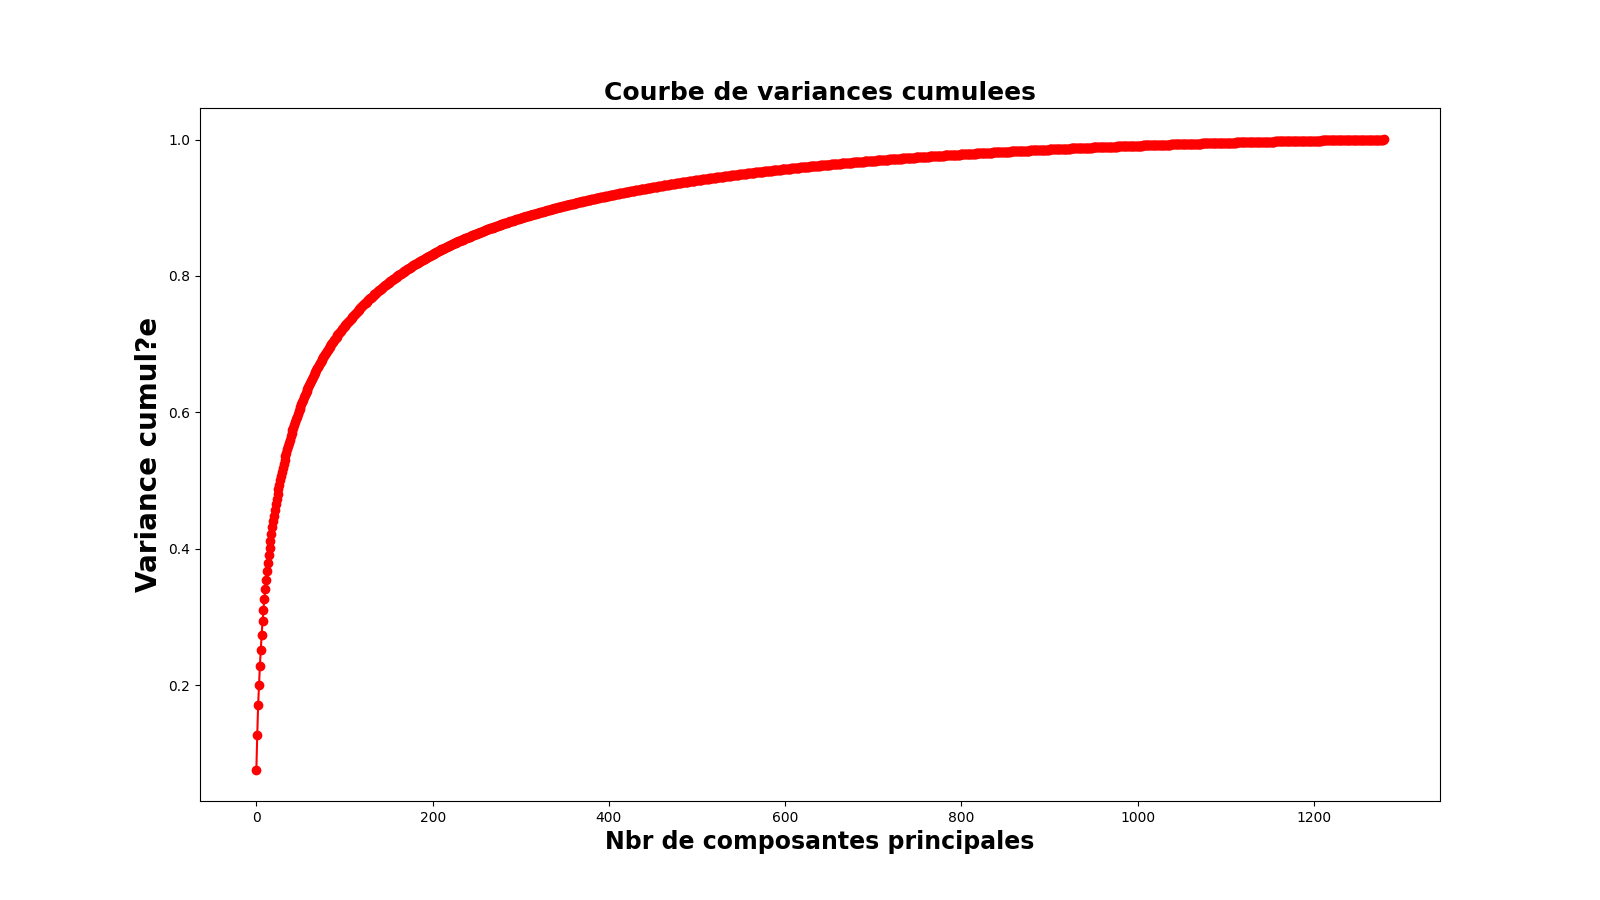

In [24]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explainedVariance.cumsum(),c="red",marker='o')
plt.title('Courbe de variances cumulees', size=18, weight='bold')
%matplot plt

In [25]:
cumsum = 0
for i in pca.explainedVariance.cumsum():
    cumsum += 1
    if(i > 0.95):
        print(
            '{} composantes expliquent 95% de la variance'.format(cumsum))
        break

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

557 composantes expliquent 95% de la variance

In [26]:
# Réduction de dimention
pca = PCA(
    k=cumsum,
    inputCol='scaledFeatures',
    outputCol='reducedscaledFeatures')
model_pca = pca.fit(df_scaled)
df_scaled_final = model_pca.transform(df_scaled)
df_scaled_final = df_scaled_final.drop("scaledFeatures")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 3.10.6.2 Affichage des catégories en 2 dimensions

In [29]:
n_components = 2
pca_2D = PCA(
    k = n_components, 
    inputCol = 'reducedscaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled_final)

df_pca = pca_2D.transform(df_scaled_final)
print('Explained Variance Ratio', pca_2D.explainedVariance.toArray())
df_pca.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Explained Variance Ratio [0.08075223 0.05305577]
+--------------------+--------------+--------------------+--------------------+---------------------+--------------------+
|                path|         label|            features| features_vectorized|reducedscaledFeatures|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+---------------------+--------------------+
|s3://ad-p8-data/T...|    Watermelon|[0.005011296, 0.2...|[0.00501129589974...| [-15.389264725713...|[15.3892647257130...|
|s3://ad-p8-data/T...|    Watermelon|[0.14366496, 0.14...|[0.14366495609283...| [-16.491550130284...|[16.4915501302845...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5370426, ...|[0.0,4.5370426177...| [-6.8697823475798...|[6.86978234757987...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.957976, 0...|[0.0,4.9579758644...| [-12.172784788366...|[12.1727847883660...|
|s3://ad-p8-data/T...|Pineapple Mini|[0.0, 4.5827317, ...|[0.0,4.5827317237...| [-8.185996

In [30]:
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Afficher les 5 premières lignes de la PCA
X_pca[:5]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[15.38926473, -3.50246135],
       [16.49155013, -3.87478245],
       [ 6.86978235, -5.38963153],
       [12.17278479, -6.4530742 ],
       [ 8.18599609, -4.50654234]])

In [32]:
# La catégorie associée à chaque image dans une liste
y = df_pca.rdd.map(lambda row: row.label).collect()
y = np.array(y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
#Afficher toutes les catégories
np.unique(y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1',
       'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith',
       'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
       'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2',
       'Apricot', 'Avocado', 'Avocado ripe', 'Banana',
       'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry',
       'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula',
       'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier',
       'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
       'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk',
       'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
       'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink',
       'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4',
       'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut',
       'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lem

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

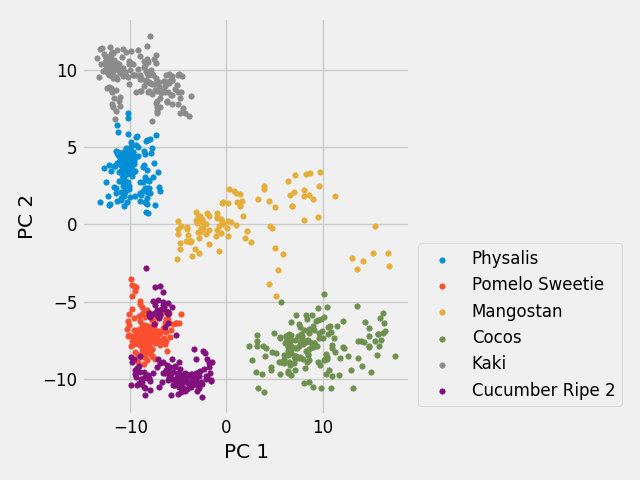

In [34]:
# change default style figure and font size
plt.figure()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_pca(X_pca, y):
    """Afficher aléatoirement 6 des catégories en 2 dimensions"""
    colors = list(plt.rcParams['axes.prop_cycle'])
    # Enregistrer dans une liste l'ensemble des catégories
    target = np.unique(y)
    # Initialiser la comptabilisation des catégories
    count = 0
    # Choix aléatoire de 6 catégories dans une boucle
    for idx,t in enumerate(np.random.choice(np.unique(y),6)):
        subset = X_pca[y == t]
        # Afficher pour chaque catégorie une représentation en 2D de ses données
        plt.scatter(subset[:, 0], subset[:, 1], s = 15,
                    c = colors[count]['color'], label = t)
        # Passer à la prochaine catégorie à afficher
        count += 1

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left',bbox_to_anchor=(1, 0., 0., 1))
    plt.tight_layout()
    plt.show()

plot_pca(X_pca, y)
%matplot plt

### 3.10.7 Enregistrement des données

In [35]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://ad-p8-data/Results

In [36]:
df_scaled_final.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.10.8 Chargement des données enregistrées et validation du résultat

In [37]:
df = spark.read.parquet(PATH_Result)
df = df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['path', 'label', 'features', 'features_vectorized',
       'reducedscaledFeatures'],
      dtype='object')

In [39]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                              path  ...                              reducedscaledFeatures
0    s3://ad-p8-data/Test/Watermelon/r_109_100.jpg  ...  [-14.430406791259037, 3.8015283557110973, -4.7...
1     s3://ad-p8-data/Test/Watermelon/r_71_100.jpg  ...  [-13.578752612872949, 4.2372964196392955, -4.4...
2     s3://ad-p8-data/Test/Watermelon/r_77_100.jpg  ...  [-15.910380276803188, 3.0335258239653777, -6.5...
3   s3://ad-p8-data/Test/Pineapple Mini/30_100.jpg  ...  [-8.493664424645026, 5.818434342546333, 2.3703...
4  s3://ad-p8-data/Test/Pineapple Mini/275_100.jpg  ...  [-4.946341399289469, 4.784781795250275, 5.0942...

[5 rows x 5 columns]

In [40]:
df.loc[0,'features_vectorized'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [41]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22688, 5)

<u>On peut également constater la présence des fichiers <br />
    au format "**parquet**" sur le **serveur S3**</u> :

![Affichage des résultats sur S3](img/S3_Results.png)

## 3.11 Suivi de l'avancement des tâches avec le Serveur d'Historique Spark

Il est possible de voir l'avancement des tâches en cours <br />
avec le **serveur d'historique Spark**.

![Accès au serveur d'historique spark](img/EMR_serveur_historique_spark_acces.png)

**Il est également possible de revenir et d'étudier les tâches <br />
qui ont été réalisé, afin de debugger, optimiser les futurs <br />
tâches à réaliser.**

<u>Lorsque la commande "**features_df.write.mode("overwrite").parquet(PATH_Result)**" <br />
était en cours, nous pouvions observer son état d'avancement</u> :

![Progression execution script](img/EMR_jupyterhub_avancement.png)

<u>Le **serveur d'historique Spark** nous permet une vision beaucoup plus précise <br />
de l'exécution des différentes tâche sur les différentes machines du cluster</u> :

![Suivi des tâches spark](img/EMR_SHSpark_01.png)

On peut également constater que notre cluster de calcul a mis <br />
un tout petit peu **moins de 8 minutes** pour traiter les **22 688 images**.

![Temps de traitement](img/EMR_SHSpark_02.png)


## 3.12 Résiliation de l'instance EMR

Notre travail est maintenant terminé. <br />
Le cluster de machines EMR est **facturé à la demande**, <br />
et nous continuons d'être facturé même lorsque <br />
les machines sont au repos.<br />
Pour **optimiser la facturation**, il nous faut <br />
maintenant **résilier le cluster**.

<u>Je réalise cette commande depuis l'interface AWS</u> :

1. Commencez par **désactiver le tunnel ssh dans FoxyProxy** pour éviter des problèmes de **timeout**.
![Désactivation de FoxyProxy](img/EMR_foxyproxy_desactivation.png)
2. Cliquez sur "**Résilier**"
![Cliquez sur Résilier](img/EMR_resiliation_01.png)
3. Confirmez la résiliation
![Confirmez la résiliation](img/EMR_resiliation_02.png)
4. La résiliation prend environ **1 minute**
![Résiliation en cours](img/EMR_resiliation_03.png)
5. La résiliation est effectuée
![Résiliation terminée](img/EMR_resiliation_04.png)

## 3.13 Cloner le serveur EMR (si besoin)

Si nous devons de nouveau exécuter notre notebook dans les mêmes conditions, <br />
il nous suffit de **cloner notre cluster** et ainsi en obtenir une copie fonctionnelle <br />
sous 15/20 minutes, le temps de son instanciation.

<u>Pour cela deux solutions</u> :
1. <u>Depuis l'interface AWS</u> :
 1. Cliquez sur "**Cloner**"
   ![Cloner un cluster](img/EMR_cloner_01.png)
 2. Dans notre cas nous ne souhaitons pas inclure d'étapes
   ![Ne pas inclure d'étapes](img/EMR_cloner_02.png)
 3. La configuration du cluster est recréée à l’identique. <br />
    On peut revenir sur les différentes étapes si on souhaite apporter des modifications<br />
    Quand tout est prêt, cliquez sur "**Créer un cluster**"
  ![Vérification/Modification/Créer un cluster](img/EMR_cloner_03.png)
2. <u>En ligne de commande</u> (avec AWS CLI d'installé et de configuré et en s'assurant <br />
   de s'attribuer les droits nécessaires sur le compte AMI utilisé)
 1. Cliquez sur "**Exporter AWS CLI**"
 ![Exporter AWS CLI](img/EMR_cloner_cli_01.png)
 2. Copier/Coller la commande **depuis un terminal**
 ![Copier Coller Commande](img/EMR_cloner_cli_02.png)

## 3.14 Arborescence du serveur S3 à la fin du projet

<u>Pour information, voici **l'arborescence complète du bucket S3 ad-p8-data** à la fin du projet</u> : <br />
*Par soucis de lisibilité, nous ne listons pas les sous dossiers des répertoires "Test" et "journal"*

1. journal/
1. journal/j-13QK17GH2QIGM/
1. journal/j-1TIWY4FV47ZSW/
1. journal/j-1WHB41BXKNE9H/
1. journal/j-25S4BK1P15BJ7/
1. journal/j-268OPJOUM6T5B/
1. journal/j-2EOPODZETXJ7G/
1. journal/j-2UCR289GVZNFG/
1. journal/j-2VGE1DCIR3AK1/
1. journal/j-38UQFM78JQ0OZ/
1. journal/j-Y2JN2IZSIPHR/
1. Results/_SUCCESS
1. Results/part-00000-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00001-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00002-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00003-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00004-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00005-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00006-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00007-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00008-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00009-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00010-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00011-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00012-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00013-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00014-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00015-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00016-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00017-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00018-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00019-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00020-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00021-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00022-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00023-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Test/
1. bootstrap-emr.sh
1. jupyter/jovyan/.s3keep
1. jupyter/jovyan/P8_01_Notebook.ipynb

# 4. Conclusion

Nous avons réalisé ce projet **en deux temps** en tenant <br />
compte des contraintes qui nous ont été imposées.

Nous avons créé un **réel cluster de calculs**. <br />
L'objectif était de pouvoir **anticiper une future augmentation de la charge de travail**.

Le meilleur choix retenu a été l'utilisation du prestataire de services **Amazon Web Services** <br />
qui nous permet de **louer à la demande de la puissance de calculs**. <br />
Ce service se nomme **EC2** et se classe parmi les offres **Infrastructure As A Service** (IAAS).

Nous sommes allez plus loin en utilisant un service de plus <br />
haut niveau (**Plateforme As A Service** PAAS)<br />
en utilisant le service **EMR** qui nous permet d'un seul coup <br />
d'**instancier plusieurs serveur (un cluster)** sur lesquels <br />
nous avons pu demander l'installation et la configuration de plusieurs<br />
programmes et librairies nécessaires à notre projet comme **Spark**, <br />
**Hadoop**, **JupyterHub** ainsi que la librairie **TensorFlow**.

En plus d'être plus **rapide et efficace à mettre en place**, nous avons <br />
la **certitude du bon fonctionnement de la solution**, celle-ci ayant été <br />
préalablement validé par les ingénieurs d'Amazon.

Nous avons également pu installer, sans difficulté, **les packages <br />
nécessaires sur l'ensembles des machines du cluster**.

Enfin, avec très peu de modification, et plus simplement encore, <br />
nous avons pu **exécuter notre notebook**.<br />
Nous avons exécuté le traitement sur **l'ensemble des images de notre dossier "Test"**.

Nous avons opté pour le service **Amazon S3** pour **stocker les données de notre projet**. <br />
S3 offre, pour un faible coût, toutes les conditions dont nous avons besoin pour stocker <br />
et exploiter de manière efficace nos données.<br />
L'espace alloué est potentiellement **illimité**, mais les coûts seront fonction de l'espace utilisé.

Il nous sera **facile de faire face à une montée de la charge de travail** en **redimensionnant** <br />
simplement notre cluster de machines (horizontalement et/ou verticalement au besoin), <br />
les coûts augmenteront en conséquence mais resteront nettement inférieurs aux coûts engendrés <br />
par l'achat de matériels ou par la location de serveurs dédiés.